In [1]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
#from plotting import plot_steps
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

In [2]:
txt = "lightcurve_6478_2005_04_03_and_2019_02_09_oringinal_date_mjd_utc_mag_mag_unc_all_mags_converted_to_r_light_time_and_geometry_corrected.txt"
data = pd.read_csv(txt, delim_whitespace=True, header=None)

In [3]:
data.head()

,0,1,2
0,53463.280132,14.349831,0.005213
1,53463.284334,14.324832,0.018947
2,53463.287679,14.307932,0.018913
3,53463.290850,14.244732,0.018973
4,53463.297690,14.209332,0.019005


In [6]:
tsample = data[0]
fsample = data[1]
flux_err = data[2]

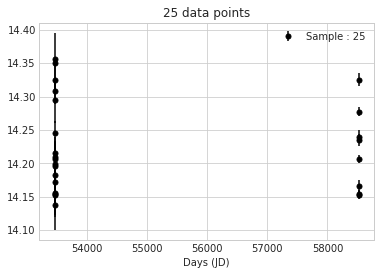

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title("%i data points"%(len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [10]:
(tsample.iloc[-1]-tsample[0])/365

13.86329176562359

In [11]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(17.75, 0.5).logpdf(params[0])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    p_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[3])
    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior


def logl(params, gp, tsample, fsample, flux_err):
    
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike


def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25


In [12]:
ndim, nwalkers = 4, 100

In [18]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = np.log(0.5)

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


In [21]:
threads=16
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp

In [22]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 60000)

CPU times: user 1h 3s, sys: 5min 49s, total: 1h 5min 52s
Wall time: 1h 28min 17s


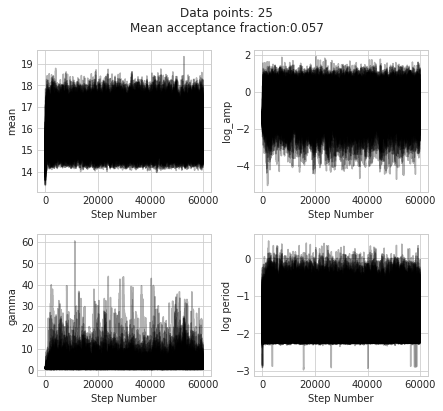

In [23]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

Text(0.5,0,'Period (hours)')

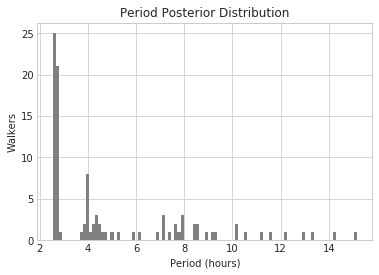

In [24]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24., bins=100, color='grey')
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

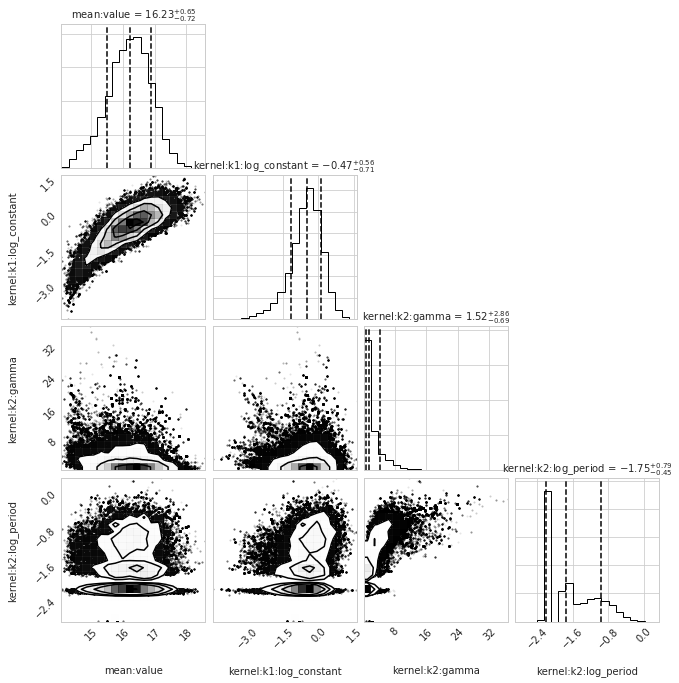

In [25]:
# make some labels
labels = list(gp.get_parameter_names())
#labels[3] = 'period'

# percentage of steps to plot
percent = 0.1

# generate list of last steps spanning backwards
x = list(range(-1,-int(sampler.iterations*percent)-1,-1))

# only plot x last steps
# reshape into 2d array instead of 3d
#sampler.chain[walker, step, param]
figure = corner.corner(sampler.chain[:,x,:].reshape(int(sampler.iterations*percent*sampler.k),4), 
                       labels=labels, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 10})

The distribution of periods ended up looking like this.

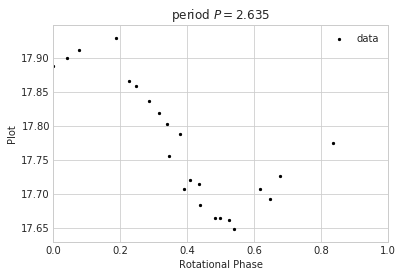

In [16]:
periods = np.exp(sampler.chain[:,-1,-1])
best_period = np.median(periods)
plot_folded_lightcurve(tsample, fsample, best_period)

In [167]:
x = np.log(sampler.flatchain.T[3]/24.)
x

array([-2.22978316, -2.22978316, -2.22978316, ..., -1.03293023,
       -1.03293023, -0.45859214])

In [168]:
sampler.flatchain.T[3] =x
sampler.flatchain.T[3]

array([-2.22978316, -2.22978316, -2.22978316, ..., -1.03293023,
       -1.03293023, -0.45859214])

We can now see how the different posterior distributions model the original sampled data. Feel free to give the file names **namestr** an appropriate title.

In [ ]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

filename = "5318_new_priors"

save_chain(filename + "_results.txt", sampler)

In [30]:
#%load_ext autoreload
%autoreload

[16.3589176  -0.86476515  3.07496769 -0.63634735]
[15.84856308 -0.04447424  8.12066402 -0.59128532]
[16.04608075 -0.4257742   1.14519686 -2.20147099]
[14.74851919 -2.06893536  9.42910124 -1.3121824 ]
[16.56779925 -0.71619362  1.14232669 -2.24055413]
[16.47094859 -0.74328521  0.78789107 -2.18972202]
[15.79408101 -0.88520161  1.47967171 -2.19242341]
[17.23139645  0.3439296   0.47277966 -2.1936131 ]
[16.19330784 -0.56426364  8.01643373 -0.83513273]
[16.84140208 -0.42267259  0.40599216 -2.19869327]


<IPython.core.display.Javascript object>


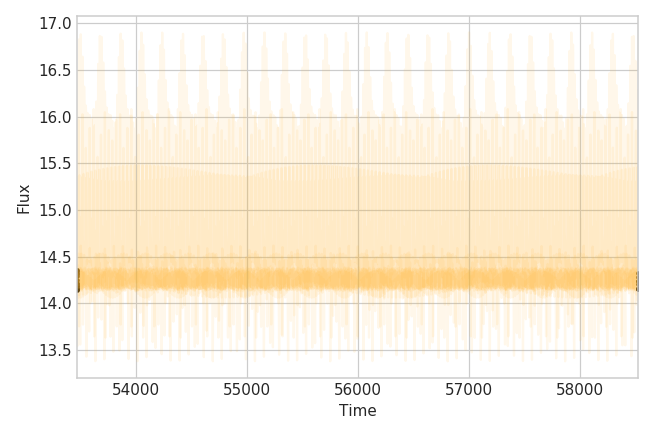

<IPython.core.display.Javascript object>


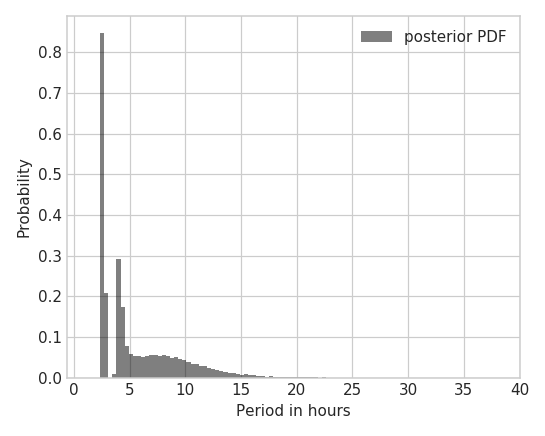

<IPython.core.display.Javascript object>


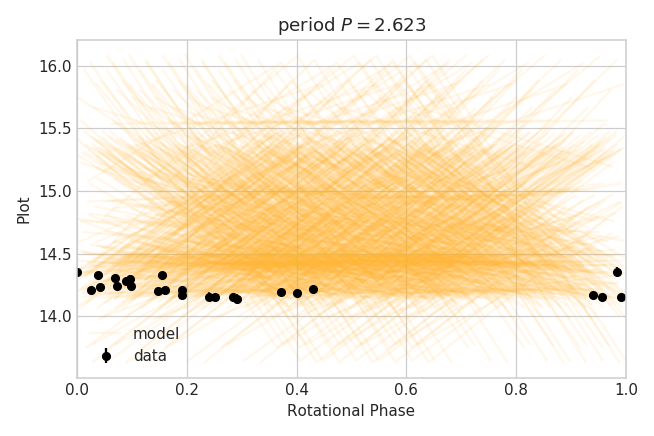

<IPython.core.display.Javascript object>


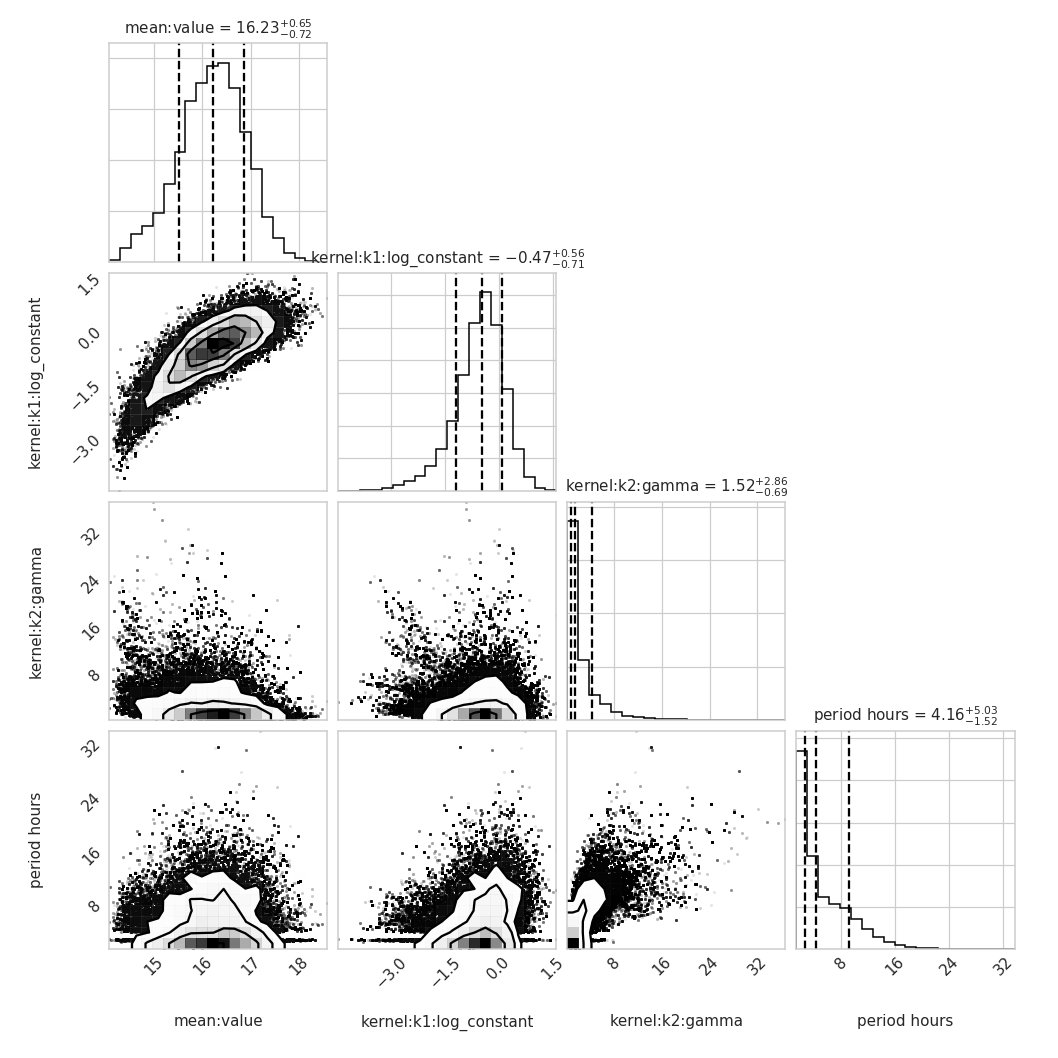

<IPython.core.display.Javascript object>


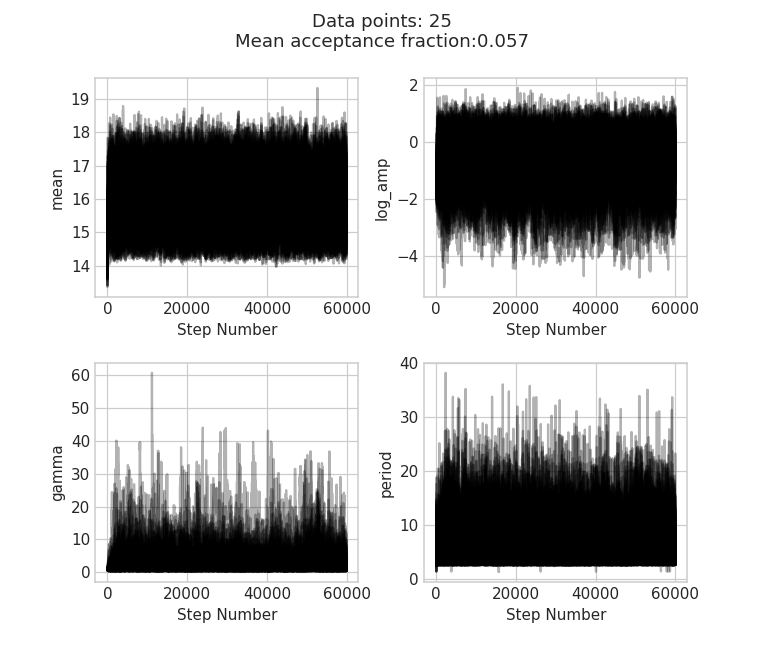

In [122]:
plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, 
                           namestr="6478_2005+2019" + "_plots", true_lightcurve=None, 
                           true_period=None)

###test failure with plotting if steps are too few

In [266]:
periods = sampler.chain[:,-1,3]
sorted(periods)

[-2.24634071029191,
 -2.239502748884846,
 -2.2255416985657,
 -2.2249429658703304,
 -2.2247735282966166,
 -2.2243616216035735,
 -2.2220907900388833,
 -2.2220052348442882,
 -2.215951636102741,
 -2.214485283212815,
 -2.213798064596008,
 -2.21351541678234,
 -2.2130843835320335,
 -2.2115708896694914,
 -2.210552412855488,
 -2.2100923031337665,
 -2.2082010897904887,
 -2.206884035780811,
 -2.204663618046183,
 -2.2017804805921855,
 -2.2012314641380906,
 -2.2001394112356696,
 -2.1995490139213216,
 -2.19851058095118,
 -2.1981223527673355,
 -2.197394820725732,
 -2.195599364984312,
 -2.1946522571370064,
 -2.192667965326636,
 -2.1911426957551647,
 -2.190483440819972,
 -2.190438489520363,
 -2.1901421674569965,
 -2.190031969246409,
 -2.1886913410031865,
 -2.1881942725022587,
 -2.187729406494781,
 -2.1874276330543676,
 -2.187329911097255,
 -2.185941471108439,
 -2.18487029877685,
 -2.1791840387722283,
 -2.175424042845141,
 -2.174137020893385,
 -2.1699808444412105,
 -2.168299578506001,
 -2.15056036444248

In [255]:
np.mode(periods)

AttributeError: module 'numpy' has no attribute 'mode'

In [286]:
period = np.exp(-2.2220052348442882)*2

In [287]:
phase = np.array(tsample)/period % 1
#phase *= (2.*np.pi)

<IPython.core.display.Javascript object>


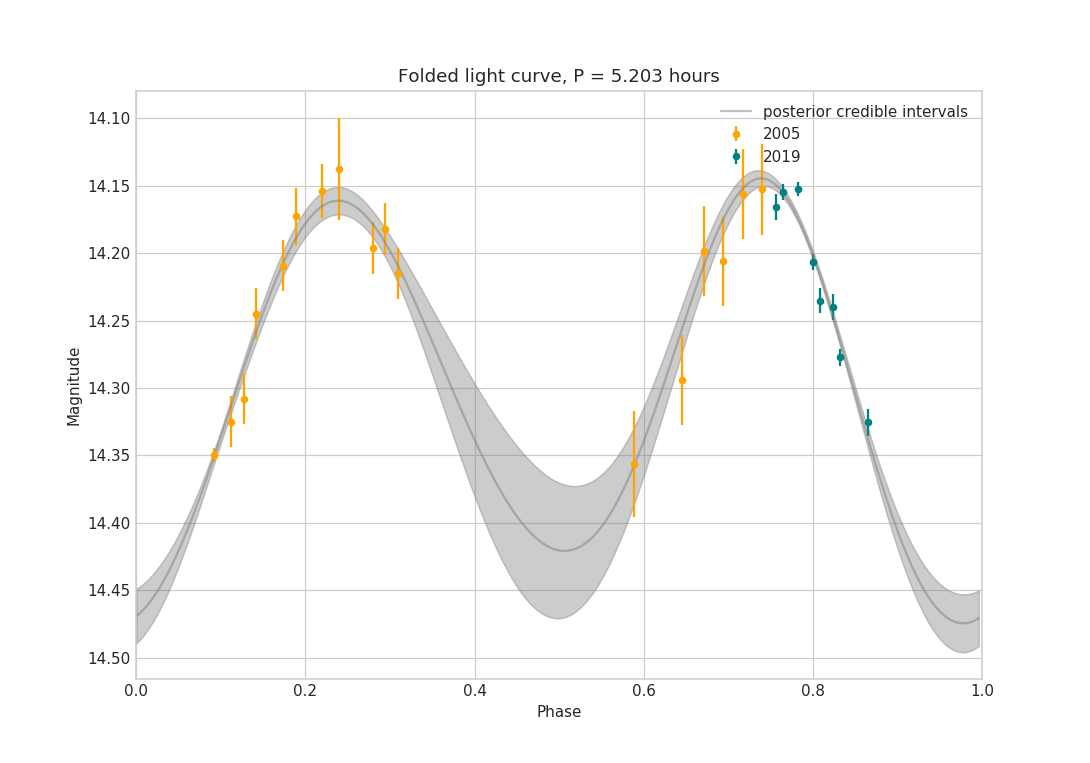

In [288]:
# plot original data phased

plt.figure(figsize=(10, 7))
plt.errorbar(phase[:17], fsample[:17], yerr=flux_err[:17],
             color="orange", fmt="o", markersize=4, label="2005")

plt.errorbar(phase[17:], fsample[17:], yerr=flux_err[17:],
             color="teal", fmt="o", markersize=4, label="2019")


kernel = np.exp(-3.75895736)*george.kernels.ExpSine2Kernel(gamma=1.5, log_period=np.log(period)) #optimal gamma was ~15
gp = george.GP(kernel, fit_mean=True, mean=np.mean(fsample))
gp.compute(tsample,flux_err)

model_time = np.arange(0, period, 0.001)
pred, pred_var = gp.predict(fsample, model_time, return_var=True)


# plot the kernel-fitted guess

plt.fill_between(model_time/period % 1, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="grey", alpha=0.4)
plt.plot(model_time/period % 1, pred, "grey", lw=1.5, alpha=0.5, label="posterior credible intervals")


# finishing touches

plt.title(r"Folded light curve, P = " +str(round(period*24,3)) + " hours")
plt.xlim([0,1])
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()
plt.legend()

<IPython.core.display.Javascript object>


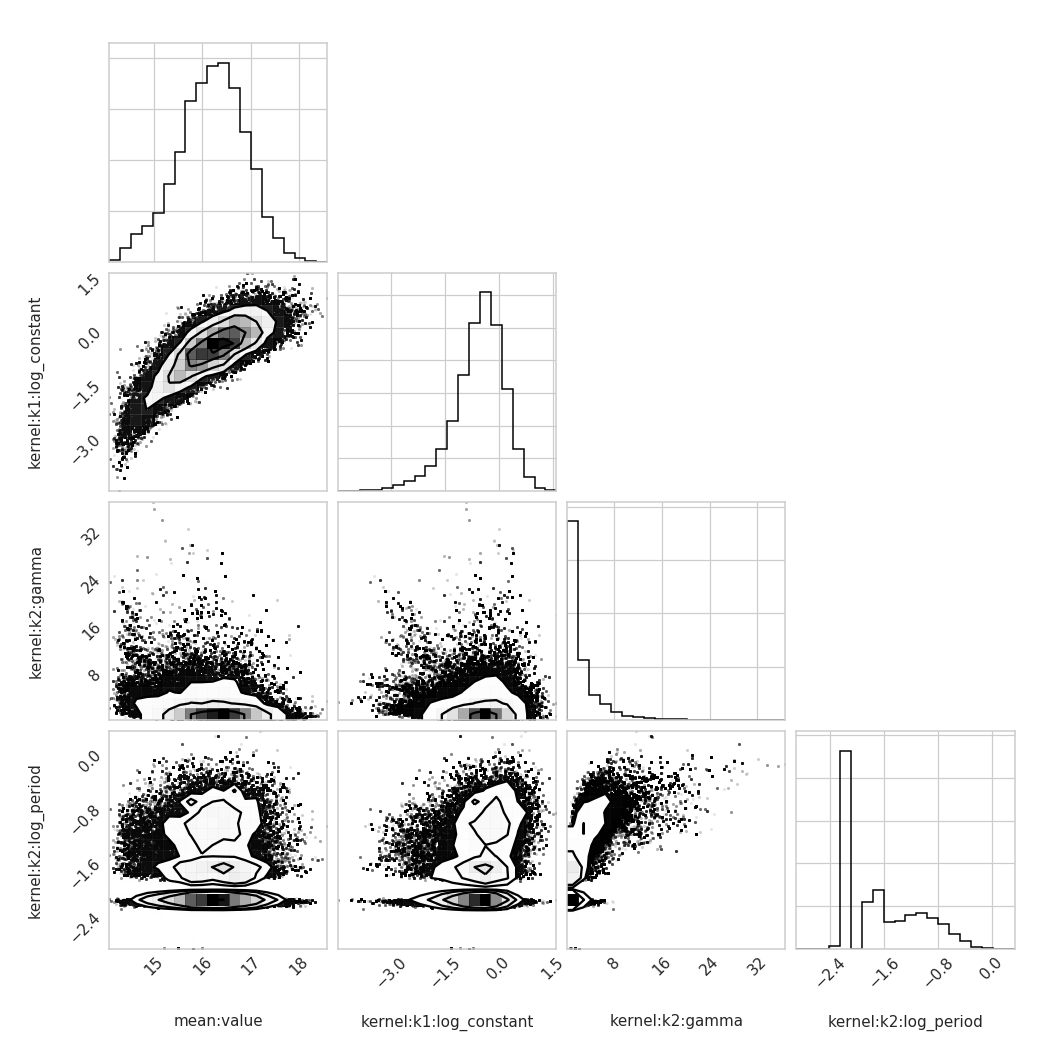

In [243]:
# generate list of last steps spanning backwards
x = list(range(-1,-int(sampler.iterations*percent)-1,-1))

labels = list(gp.get_parameter_names())

# only plot x last steps
# reshape into 2d array instead of 3d
#sampler.chain[walker, step, param]
figure = corner.corner(sampler.chain[:,x,:].reshape(int(sampler.iterations*percent*sampler.k),4), 
                       labels=labels)

<IPython.core.display.Javascript object>


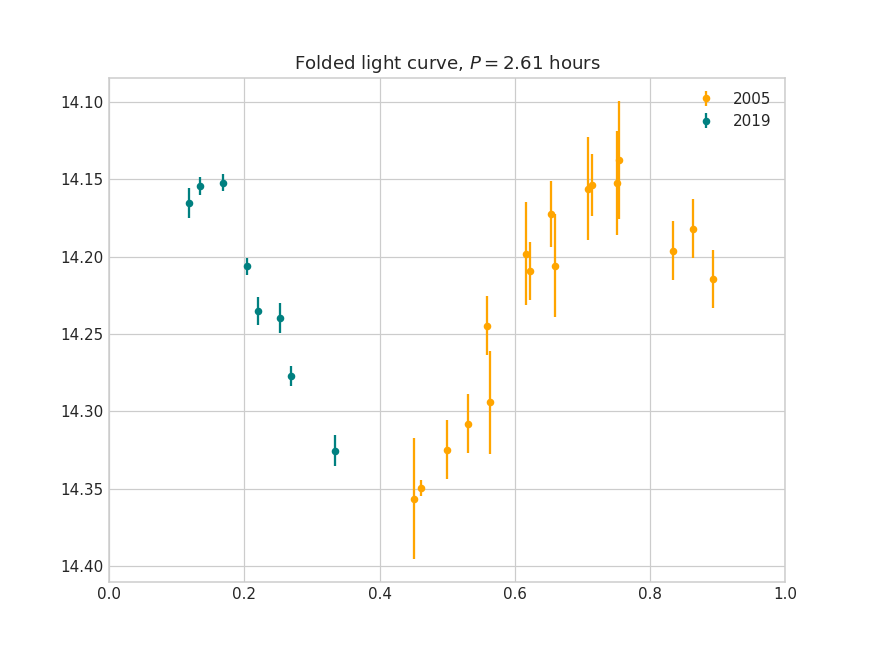

In [207]:
fig, ax3 = plt.subplots(figsize=(8,6))

ax3.errorbar(phase[:17], fsample[:17], yerr=flux_err[:17],
             color="orange", fmt="o", markersize=4, label="2005")

ax3.errorbar(phase[17:], fsample[17:], yerr=flux_err[17:],
             color="teal", fmt="o", markersize=4, label="2019")

ticks = [0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
labels = ["0", r"$\frac{1}{2}\pi$", r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"]
#ax3.set_xticks(ticks)
#ax3.set_xticklabels(labels)
ax3.set_title(r"Folded light curve, $P = 2.61$ hours")
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlim([0,1])
ax3.legend()

In [145]:
def sinusoid(t, logamp, period, bkg):
    """
    A sinusoidal model.
    
    Parameters
    ----------
    t : iterable
        The dependent coordinate
        
    logamp : float
        The logarithm of the sinusoidal amplitude
        
    period : float
        The period of the sinusoid
        
    phase : float [0, 2*pi]
        The phase of the sinusoidal signal
        
    bkg : float
        The mean magnitude
    
    Returns
    -------
    res : numpy.ndarray
        The result
    """
    res = np.exp(logamp) * np.sin(2.*np.pi*t/period) + bkg
    return res

<IPython.core.display.Javascript object>


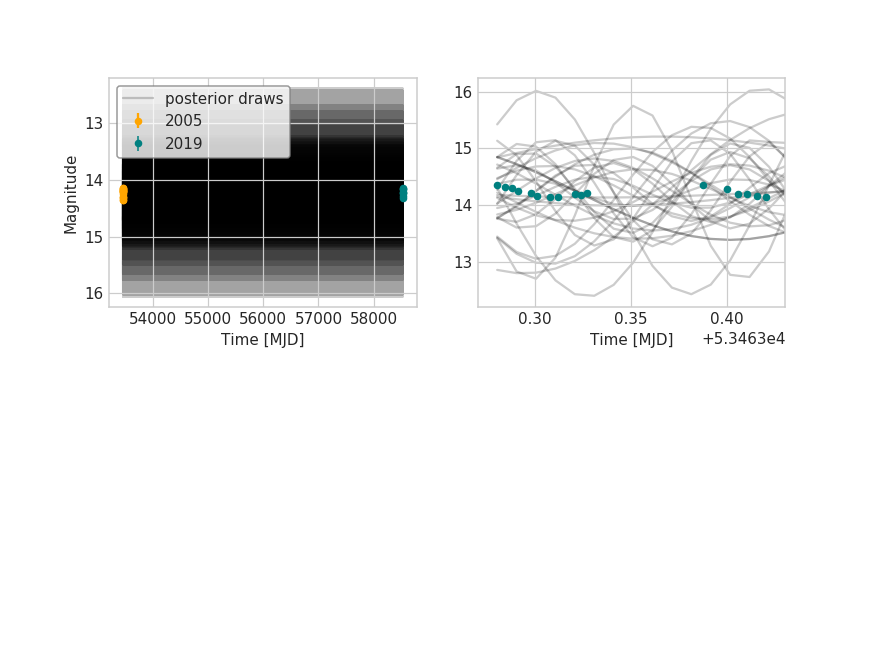

-0.09256567570222506
-0.07450312430683033
-0.09215128847230498
-0.07017862166030431
-0.020860297271148787
-0.09123015077026059
-0.07365144366332753
-0.06405525578240152
-0.0749456797358089
-0.09108975836920104
-0.07468185231640763
-0.09200203443005543
-0.0905780715221169
-0.09223488925831874
-0.0476351886851446
-0.07678662048819383
-0.04796722731848021
-0.05064250762270376
-0.09429036567763488
-0.09188872209132913
-0.05083985201062841
-0.09213756047139854
-0.07493477507553546
-0.04608499404236696
-0.07103024264153303
-0.09333132566250184
-0.06864864898178218
-0.056383620647714676
-0.09218535180121618
-0.04796722731848021


Text(0.5,0,'Time [MJD]')

In [175]:
#fig, (ax1, ax2) = plt.subplots(,2, figsize=(8,4))

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
#ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)


ax1.errorbar(tsample[:17], fsample[:17], yerr=flux_err[:17],
             color="orange", fmt="o", markersize=4, label="2005")

ax1.errorbar(tsample[17:], fsample[17:], yerr=flux_err[17:],
             color="teal", fmt="o", markersize=4, 
             lw=1, label="2019")


ax2.errorbar(tsample, fsample, yerr=flux_err,
             color="teal", fmt="o", lw=1, markersize=4, 
             label="all")

flatchain = np.concatenate(sampler.chain[:,-1000:, :], axis=0)
model_time = np.linspace(tsample[0], tsample.iloc[-1], 500000)
for i in range(30):
    # Choose a random walker and step.
    w = np.random.randint(flatchain.shape[0])
    p = flatchain[w]
    print(p[3]/24.)
    #ph = (p[2]/(2.0*np.pi) - int(p[2]/(2.0*np.pi))) * 2 * np.pi
    m = sinusoid(model_time, logamp=p[1], period=np.exp(p[3]), bkg=np.mean(fsample))
#    # Plot a single sample.
    if i == 0:
        ax1.plot(model_time, m, alpha=0.2, color="black", 
                 label="posterior draws", zorder=0)
        ax2.plot(model_time, m, alpha=0.2, color="black", 
                 label="posterior draws", zorder=0)
    else:
        ax1.plot(model_time, m, alpha=0.2, color="black", zorder=0)
        ax2.plot(model_time, m, alpha=0.2, color="black", zorder=0)


#ax1.set_xlim(58055.2, 58056.32)
ax1.set_xlabel("Time [MJD]")
ax1.set_ylabel("Magnitude");
leg = ax1.legend(frameon=True)
leg.get_frame().set_edgecolor('grey')

#ax1.set_ylim(22, 25.5)
ax1.set_ylim(ax1.get_ylim()[::-1])

ax2.set_xlim(tsample[0]-0.01, (tsample[16])+0.01)
ax2.set_xlabel("Time [MJD]")
#ax2.set_yticklabels([])
#ax2.set_ylim(22, 25.5)
#ax2.set_ylim(ax2.get_ylim()[::-1])

In [49]:
gp = george.GP(kernel, mean=np.mean(fake_mag), fit_mean=True,
               white_noise=np.mean(np.log(mag_err)), fit_white_noise=False)
gp.compute(time)

x = np.linspace(np.min(time), np.max(time), 5000)
mu, var = gp.predict(fake_mag, x, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(8,4))
plt.errorbar(time, fake_mag, yerr=mag_err,
             color="black", fmt="o", markersize=4)
plt.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

#plt.xlim(58054, np.max(time)+0.3)
plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude");

NameError: name 'fake_mag' is not defined